# Health Insurance Cross Sell Prediction

## Introduction
Vehicle insurance companies charge a premium on their customers in exchange for compensation for damage, illness or death. To improve on their business model, they are interested in learning about what type of customers will buy their vehicle insurance based on the price of the premium and the demographics of the customer. In doing so, this can help maximize revenue and efficiently allocate marketting towards interested customers.

We will be looking at a dataset provided on kaggle.com for an insurance company. This dataset contains various variables with a response on whether or not a customer is interested in buying the vehicle insurance. A link to the dataset along with it's decription can be found [here](https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction). We are interested in predicting whether or not a customer would be interested in purchasing vehicle insurance, as well which variables are important for this prediction. We are doing a binary classification, with class 0 being the customers that are not interested, and class 1 being the customers that are interested in purchasing the vehicle insurance. To do so, we will be using 3 classification models: logistic regression, random forest, and a neural network. We will then compare the 3 models and analyze the results. 

## Varaible Summary
Taken from the kaggle page:

* `id`	Unique ID for the customer
* `Gender`	Gender of the customer
* `Age`	Age of the customer
* `Driving_License	0` : Customer does not have DL, 1 : Customer already has DL
* `Region_Code`	Unique code for the region of the customer
* `Previously_Insured`	1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance
* `Vehicle_Age`	Age of the Vehicle
* `Vehicle_Damage`	1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.
* `Annual_Premium`	The amount customer needs to pay as premium in the year
* `PolicySalesChannel`	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
* `Vintage`	Number of Days, Customer has been associated with the company
* `Response`	1 : Customer is interested, 0 : Customer is not interested

In [71]:
import pandas as pd
from sklearn import model_selection
import matplotlib.pyplot as plt
from pylab import xticks
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn import neural_network
from sklearn import preprocessing, pipeline, model_selection
from sklearn.neural_network import MLPRegressor

In [77]:
# constants
k_fold = 3 # number of folds to use in k-fold cross validation
np.random.seed(323)

In [3]:
# read the labelled data from github
URL="https://raw.githubusercontent.com/gordonnng/ECON-323---Health-Insurance-Cross-Sell-Prediction/main/train.csv"
df=pd.read_csv(URL, index_col=0) # data
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## Exploratory Analysis
First we will start by conducting an exploratory analysis on the data provided.

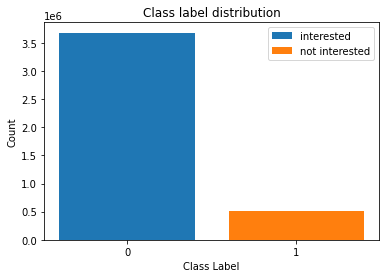

In [4]:
df_0 = df.loc[df["Response"] == 0] # customers who are not interested in the vehicle insurance offered
df_1 = df.loc[df["Response"] == 1] # customers who are interested in the vehicle insurance offered

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(0, df_0.size,label="interested" )
ax.bar(1, df_1.size,label="not interested" )
ax.set_xticks(range(0,2))

plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Class label distribution")
plt.legend()
# plt.text(0.75,200000,"\n".join(("Class 0: not interested", "Class 1: interested")), verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

In [5]:
print(f"{round(df_0.size/(df_0.size+df_1.size),4)*100}% belong to class 0")

87.74% belong to class 0


First we notice that there is an unbalanced class distribution in the data provided, which should be noted when we construct our classification models. About 88% of the data belong to class 0 (customers who are not interested in purchasing insurance).

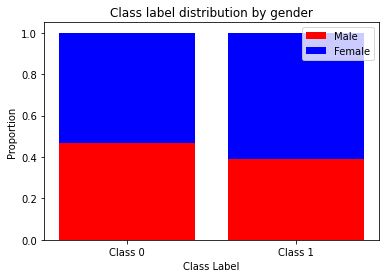

In [6]:
num_female_class0 = df_0.loc[df_0["Gender"] == "Female"].size # number of females in class 0
num_female_class1 = df_1.loc[df_1["Gender"] == "Female"].size # number of females in class 1
num_male_class0 = df_0.loc[df_0["Gender"] == "Male"].size # number of males in class 0
num_male_class1 = df_1.loc[df_1["Gender"] == "Male"].size # number of males in class 1

plt.bar(0, num_female_class0/df_0.size, color="r")
plt.bar(0, num_male_class0/df_0.size, bottom=num_female_class0/df_0.size, color="b")

plt.bar(1, num_female_class1/df_1.size, color="r")
plt.bar(1, num_male_class1/df_1.size, bottom=num_female_class1/df_1.size, color="b")

plt.xticks([0,1], ["Class 0", "Class 1"])

plt.xlabel("Class Label")
plt.ylabel("Proportion")
plt.title("Class label distribution by gender")
plt.legend(["Female","Male"])

From the above plot, we notice that there is a roughly equal proportion of males and females in each class, however it should be noted that there is a larger proportion of males who are interested in vehicle insurance.

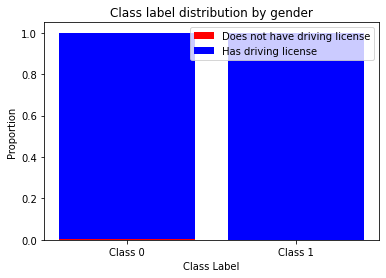

In [184]:
plt.bar(0, df_0.loc[df_0["Driving_License"] == 0].size/df_0.size, color="r")
plt.bar(0, df_0.loc[df_0["Driving_License"] == 1].size/df_0.size, bottom=df_0.loc[df_0["Driving_License"] == 0].size/df_0.size, color="b")

plt.bar(1, df_1.loc[df_1["Driving_License"] == 0].size/df_1.size, color="r")
plt.bar(1, df_1.loc[df_1["Driving_License"] == 1].size/df_1.size,bottom=df_1.loc[df_1["Driving_License"] == 0].size/df_1.size, color="b")

plt.xticks([0,1], ["Class 0", "Class 1"])

plt.xlabel("Class Label")
plt.ylabel("Proportion")
plt.title("Class label distribution by gender")
plt.legend(["Does not have driving license","Has driving license",])

From the above plot and our own intuition, we suspect that whether or not a customer has their driving license would not be a great indicator on their interest towards vehicle insurance. (I would assume that most people interested in purchasing vehicle insurance would own a vehicle and have their license.)

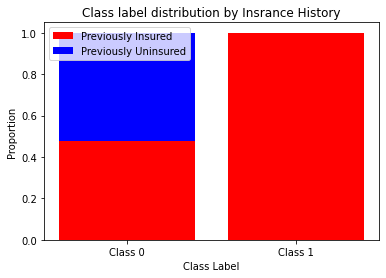

In [182]:
plt.bar(0, df_0.loc[df_0["Previously_Insured"] == 0].size/df_0.size, color="r")
plt.bar(0, df_0.loc[df_0["Previously_Insured"] == 1].size/df_0.size, bottom=df_0.loc[df_0["Previously_Insured"] == 0].size/df_0.size, color="b")

plt.bar(1, df_1.loc[df_1["Previously_Insured"] == 0].size/df_1.size, color="r")
plt.bar(1, df_1.loc[df_1["Previously_Insured"] == 1].size/df_1.size,bottom=df_1.loc[df_1["Previously_Insured"] == 0].size/df_1.size, color="b")

plt.xticks([0,1], ["Class 0", "Class 1"])

plt.xticks([0,1], ["Class 0", "Class 1"])

plt.xlabel("Class Label")
plt.ylabel("Proportion")
plt.title("Class label distribution by Insrance History")
plt.legend(["Previously Insured","Previously Uninsured"])

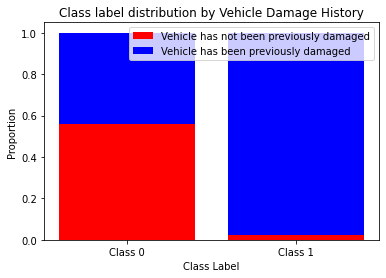

In [186]:
plt.bar(0, df_0.loc[df_0["Vehicle_Damage"] == "No"].size/df_0.size, color="r")
plt.bar(0, df_0.loc[df_0["Vehicle_Damage"] == "Yes"].size/df_0.size, bottom=df_0.loc[df_0["Vehicle_Damage"] == "No"].size/df_0.size, color="b")

plt.bar(1, df_1.loc[df_1["Vehicle_Damage"] == "No"].size/df_1.size, color="r")
plt.bar(1, df_1.loc[df_1["Vehicle_Damage"] == "Yes"].size/df_1.size,bottom=df_1.loc[df_1["Vehicle_Damage"] == "No"].size/df_1.size, color="b")

plt.xticks([0,1], ["Class 0", "Class 1"])

plt.xticks([0,1], ["Class 0", "Class 1"])

plt.xlabel("Class Label")
plt.ylabel("Proportion")
plt.title("Class label distribution by Vehicle Damage History")
plt.legend(["Vehicle has not been previously damaged","Vehicle has been previously damaged"])

Both insurance history and vehicle damage history appear to be good indications of the customers interest towards vehicle insurance. Customers whom have previously purchased insurance are extremly likely to be interested in continuing their interest. Also customers who have a previously damaged vehicle are also extremly likely to be interested in vehicle insurance.

## Model fitting
### Preprocessing
The data needs to be preprocessed before we fit our models. First we need to encode all of our categorical variables: Gender, Region_Code, Vehicle_Age, Vehicle_Damage, and Policy_Sales_Channel as integers.

In [10]:
x=df.iloc[:,1:-1] # predictor variables
y=df.iloc[:,-1] # response variable

x=pd.get_dummies(x) # encode the cateogrical variables

Next we are interested in scaling all of our data. This will be useful for evaluating the models later. For example for logistic regression, we will be able to determine the importance of the coefficients based on their magnitudes if our data is scaled. 

In [11]:
x = pd.DataFrame(StandardScaler().fit(x).transform(x),columns = x.columns)

### Logistic Regression

In [12]:
# split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=323) # random_state for reproducibility

model_LR=LogisticRegression() # create logistic regression model
model_LR.fit(x_train,y_train)


LogisticRegression()

In [13]:
model_LR.coef_

array([[-0.39350502,  0.05517485, -0.0062229 , -1.95118506,  0.04475984,
        -0.13236246, -0.00350365,  0.26473188, -0.32662604,  0.14766685,
        -0.50894066,  0.50894066]])

In [54]:
coef_dict = {} # create a dictionary to store the coefficient names and their values
print("Coefficients")
for coef_name, coef_val in zip(x.columns, model_LR.coef_[0]):
    print(coef_name+": "+f"{coef_val}") 
    coef_dict[coef_name]=coef_val

Coefficients
Age: -0.39350501742730243
Driving_License: 0.055174846379236225
Region_Code: -0.0062228960676905
Previously_Insured: -1.9511850649627671
Annual_Premium: 0.044759839960885714
Policy_Sales_Channel: -0.13236246300873739
Vintage: -0.0035036469648083825
Vehicle_Age_1-2 Year: 0.2647318758938464
Vehicle_Age_< 1 Year: -0.32662603733881784
Vehicle_Age_> 2 Years: 0.14766684577818634
Vehicle_Damage_No: -0.5089406582285022
Vehicle_Damage_Yes: 0.5089406582285022


Since we have scaled all of our data prior to fitting the logistic regression model, we can interpret the magnitude of the coefficients as the importance of that feature.

Text(0.5, 1.0, 'Feature importance of the coefficients')

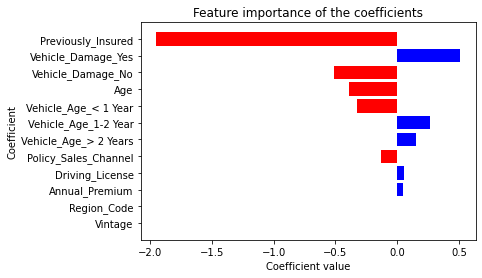

In [62]:
mag_coef=np.abs(model_LR.coef_[0]) # magnitude of the coefficients
indices=np.argsort(mag_coef) # get the order the values from largest to smalelst

colors=[]
for coef_name in x.columns[indices]:
    if coef_dict[coef_name] < 0: # check if the actual coefficient is negative
        colors.append('r') # set the color of that index to red if it is negative
    else:
        colors.append('b') # set color to blue otherwise

plt.barh(x.columns[indices], model_LR.coef_[0][indices], color=colors)
plt.xlabel("Coefficient value")
plt.ylabel("Coefficient")
plt.title("Feature importance of the coefficients")

From the above plot , it is evident that whether or not a customer has been previously insured is the most important variable for deciding if a customer would be interested in purchasing vehicle insurance. This coefficient has a negative value, which implies that if a customer was previously insured, they are less likely to purchase vehicle insurance. The next most important features are whether or not the customer has suffered vehicle damage in the past. The coefficient associated with the customer suffering vehicle damage in the past has a postive coefficient, implying that this increases the likeliness of them being interested in purchasing vehicle insurance. Next the age of the customer has a negative relationship with their interest with vehicle insurance, meaning younger customers are generally more interested in purchasing vehicle insurance. Lastly, the vehicle age is also an important characteristic. Customers with a vehicle less than 1 years old or greater than 2 years are likely to purchase insurance, while those with a vehicle age inbetween are less likely.

In [16]:
train_score_LR = model_LR.score(x_train, y_train)
test_score_LR = model_LR.score(x_test, y_test)
print('Train Accuracy Score', train_score_LR)
print('Test Accuracy Score', test_score_LR)

Train Accuracy Score 0.8774595177885577
Test Accuracy Score 0.8772664060245073


In [140]:
report_LR = metrics.classification_report(y_train, model_LR.predict(x_train),target_names=["class 0", "class 1"])
print(report_LR)

              precision    recall  f1-score   support

     class 0       0.88      1.00      0.93    267529
     class 1       0.38      0.00      0.00     37358

    accuracy                           0.88    304887
   macro avg       0.63      0.50      0.47    304887
weighted avg       0.82      0.88      0.82    304887



In [132]:
model_LR.predict_proba(x_train)[:, 1]

array([0.21314306, 0.27879506, 0.0004765 , ..., 0.00043665, 0.17966274,
       0.00206022])

In [ ]:
report_LR = metrics.classification_report(y_test, model_LR.predict(x_test),target_names=["class 0", "class 1"])
print(report_LR)

In [18]:
LR_pred = cross_val_predict(model_LR, x, y, cv=k_fold) # predicted labels based on 3-fold cross validation
LR_pred_prob = cross_val_predict(model_LR, x, y, cv=k_fold, method='predict_proba') # predicted probabilites based on 3-fold cross validation


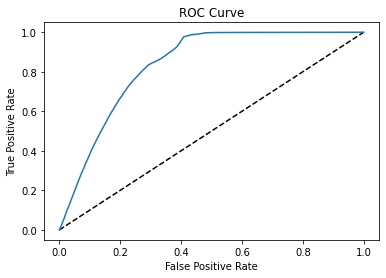

In [19]:
def plot_roc(y, probabilities):
    '''
    function modified from course notes: https://datascience.quantecon.org/applications/classification.html
    :param array y: class labels
    :param array probabilities: predicted probabilities for the class labels given
    '''
    
    # keep the second column, for label=1
    predicted_prob1 = LR_pred_prob[:, 1]

    fpr, tpr, _ = metrics.roc_curve(y, predicted_prob1)

    # Plot ROC curve
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], "k--")
    ax.plot(fpr, tpr)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")

plot_roc(y, LR_pred_prob)

In [20]:
cv_acc=accuracy_score(y, LR_pred)
print('Cross-validated accuracy Score', cv_acc)

Cross-validated accuracy Score 0.8774208953344056


In [21]:
model_RF = RandomForestClassifier(n_estimators=100, min_samples_split=2,random_state=323)

RF_pred = cross_val_predict(model_RF, x, y, cv=k_fold) # predicted labels based on 3-fold cross validation
RF_pred_prob = cross_val_predict(model_RF, x, y, cv=k_fold, method='predict_proba') # predicted probabilites based on 3-fold cross validation

model_RF.fit(x_train,y_train)

train_score_RF = model_RF.score(x_train, y_train)
test_score_RF = model_RF.score(x_test, y_test)
print('Train Accuracy Score', train_score_RF)
print('Test Accuracy Score', test_score_RF)

RandomForestClassifier(random_state=323)

In [28]:
report_RF = metrics.classification_report(y_train, model_RF.predict(x_train),target_names=["class 0", "class 1"])
print(report_RF)

              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00    267529
     class 1       1.00      1.00      1.00     37358

    accuracy                           1.00    304887
   macro avg       1.00      1.00      1.00    304887
weighted avg       1.00      1.00      1.00    304887



In [29]:
report_RF = metrics.classification_report(y_test, model_RF.predict(x_test),target_names=["class 0", "class 1"])
print(report_RF)

              precision    recall  f1-score   support

     class 0       0.89      0.97      0.93     66870
     class 1       0.37      0.14      0.20      9352

    accuracy                           0.87     76222
   macro avg       0.63      0.55      0.56     76222
weighted avg       0.82      0.87      0.84     76222



From the above, we noticed that our random forest model has a perfect f1-score in the training set for both classes. This is alarming as tree based methods are prone to overfitting. The f1-score for class 0 in the holdout set is 0.93, and 0.20 for class 1. This model appears to have overfit the data, as it performs fairly poor for predicting class 1 in our holdout set. However after tuning the parameters, we were ultimately unable to obtain a better fit than the model above. The f1-score for class 1 is an improvement over the logistic regression model earlier. We are able to sacrifice a marginal amount of precision in favor of a larger recall score in this model. I believe it is difficult to obtain a large f1-score for class 1 due to the low proportion of the data containing this class label. This could possibly be improved by implementing random or over sampling methods.

In [24]:
cv_acc_RF=accuracy_score(y, RF_pred)
print('Cross-validated accuracy Score', cv_acc_RF)

Cross-validated accuracy Score 0.8652642682277248


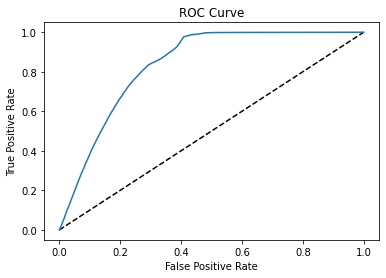

In [25]:
plot_roc(y, RF_pred_prob)

Text(0.5, 0, 'Mean decrease in impurity (Gini)')

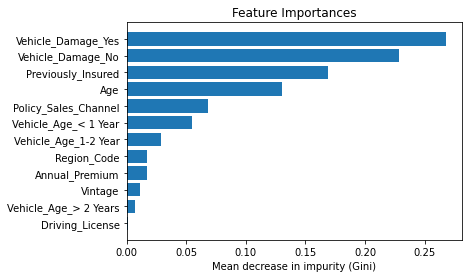

In [69]:
feat_importances = model_RF.feature_importances_
indices = np.argsort(feat_importances)
plt.title("Feature Importances")
plt.barh(x.columns[indices],feat_importances[indices])
plt.xlabel("Mean decrease in impurity (Gini)")

We can  use the mean decrease in impurity for each feature as a measure for its importance in predicting whether or not a customer is interested in vehicle insurance. From this above plot, we notice that our most important features are whether or not the customers vehicle had prior damage. Followed by whether or not they had previous insurance, and their age. These 3 factors were also determined by the logistic regression model to be the most important, however the two models ranked these features differently.

## Multilayer Perceptron Neural Network
Lastly we will fit a Multilayer Perceptron Neural Network to our data.

In [85]:
# parameters taken from course notes: https://datascience.quantecon.org/applications/ml_in_economics.html
MLP_nn = MLPRegressor((50,), activation="logistic",verbose=False, solver="adam",max_iter=400, early_stopping=True,validation_fraction=0.15) 
MLP_pred_prob = cross_val_predict(MLP_nn, x, y, cv=k_fold, method='predict') # predicted probabilites based on 3-fold cross validation


In [103]:
MLP_nn.fit(x_train,y_train)

MLPRegressor(activation='logistic', early_stopping=True,
             hidden_layer_sizes=(50,), max_iter=400, validation_fraction=0.15)

In [98]:
# get the MLP predictions based on the probabilities obtained
MLP_pred=np.abs(np.round(MLP_pred_prob,0))

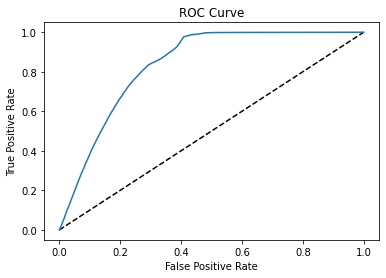

In [101]:
plot_roc(y, MLP_pred_prob)

In [100]:
cv_acc_MLP=accuracy_score(y, MLP_pred)
print('Cross-validated accuracy Score', cv_acc_MLP)

Cross-validated accuracy Score 0.8775363478689824


In [106]:
report_MLP = metrics.classification_report(y_train, np.abs(np.round(MLP_nn.predict(x_train),0)),target_names=["class 0", "class 1"])
print(report_MLP)

              precision    recall  f1-score   support

     class 0       0.88      1.00      0.93    267529
     class 1       0.61      0.00      0.00     37358

    accuracy                           0.88    304887
   macro avg       0.74      0.50      0.47    304887
weighted avg       0.84      0.88      0.82    304887
               precision    recall  f1-score   support

     class 0       0.88      1.00      0.93     66870
     class 1       0.25      0.00      0.00      9352

    accuracy                           0.88     76222
   macro avg       0.56      0.50      0.47     76222
weighted avg       0.80      0.88      0.82     76222



In [141]:
def get_class_label(predict_proba, threshold=0.5):
    '''
    :param array predict_proba: predicted probabilities for class 1
    :param float threshold: threshold for probability to be considered class 1
    :return: array of class labels
    '''
    return np.where(predict_proba>threshold, 1, 0)

In [143]:
report_MLP = metrics.classification_report(y_test, get_class_label(MLP_nn.predict(x_test), 0.5),target_names=["class 0", "class 1"])
print(report_MLP)

              precision    recall  f1-score   support

     class 0       0.88      1.00      0.93     66870
     class 1       0.62      0.00      0.00      9352

    accuracy                           0.88     76222
   macro avg       0.75      0.50      0.47     76222
weighted avg       0.85      0.88      0.82     76222



The MLP model appears to have much higher precision among predicting class 1 in both the training and holdout sets. However, it lacks the ability to recall this class.

## Threshold-Moving
An issue that was apparent before fitting any of the models was the fact that we had a very unbalanced class distribution in the dataset. So far we have not done anything to compensate for this. As a result, all of our models performed fairly poorly at predicting class 1 (customers that are interested in purchasing vehicle insurance). The logistic regression and MLP models had a recall value of 0 for the holdout sets, while random forest had a recall value of 0.2. This is ultimately not very informative if our goal is to sell more vehicle insurance, as having a low recall value could imply having a large number of false negatives. False negatives in this case would be incorrectly predictng that a customer would not be interested when they are. This would be a missed oportunity for the company. To alleviate this, we will perform something known as threshold-moving. For our classifications, we obtain predicted probabilities for a given class (class 1). So far, if these probabilities were over 0.5 (a default threshold) we would say that the prediction is class 1, and class 0 otherwise. Threshold-moving involves tuning this threshold value. We will be examining this threshold-moving below for the MLP classifier.

In [165]:
listof_precision=[]
listof_recall=[]
listof_f1_score=[]
thresholds = np.linspace(0,0.5,20)

for threshold in thresholds:
    report_MLP = metrics.classification_report(y_test, get_class_label(MLP_nn.predict(x_test), threshold),target_names=["class 0", "class 1"], output_dict=True)
    listof_precision.append(report_MLP['class 1']['precision'])
    listof_recall.append(report_MLP['class 1']['recall'])
    listof_f1_score.append(report_MLP['class 1']['f1-score'])

Text(0.5, 1.0, 'Accuracy metrics as a function of threshold')

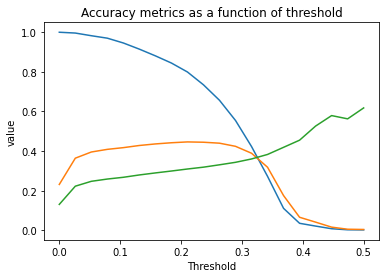

In [166]:
plt.plot(thresholds, listof_recall,label='recall')
plt.plot(thresholds, listof_f1_score, label='f1-score')
plt.plot(thresholds, listof_precision, label='precision')
plt.xlabel('Threshold')
plt.ylabel('value')
plt.title('Accuracy metrics as a function of threshold')


From the above, we have obtained the precision, recall, and f1-scores for a range of different thresholds. Without knowing anything about the company, and how they operate, I would naively choose a theshold = 0.2. For selling more vehicle insurance contracts, we are ultimately more interested in being able to predict the customers in class 1. We are trading precision for an increase in recall in this case. Having a recall value larger than the precision can be seen as beneficial as we are intrested in having less false negatives than false positives. False negatives are more deterimental as we are incorrectly predicting a customer as not being interested, meaning that we are missing out on potential customers. Having a larger amount of false positives can be seen as less detrimental as we are targetting resources to a customer who is unlikely to be interested, which is essentially an inefficient use of resources. However it may still be possible to convince these customers, so these resources are not entirely wasted. A much deeper and sophisticated analysis on this problem can be done with a cost benefit analysis if more information on the problem were known. These threshold values can be adjusted to maximimize revenue for the insurance company.

## Conclusion
In conclusion, we determined that there are 3 main factors that are important for determining whether or not a customer would be interested in purchasing vehicle insurance. These factors are: `Vehicle_Damage`, `Previously_Insured`, and `Age`. Past damage to a customers vehicle, previous purchase of vehicle insurance, and low age were all determined to be positively related towards interest in purchasing vehicle insurance. From the 3 models fitted to the data we obtained the following 3-fold cross-validated accuracy scores: logistic regression: 0.88, random forest: 0.87, multilayer perceptron neural network: 0.88. These 3 models were fairly compareable in terms of accuracy. However another metric for accuracy to be considered are the precision, recall, and f1-scores. We explored a method of threshold-moving to tune our models to maximize revenue with tradeoffs in accuracy.